# Doc 8 - Organização do dataset completo

Na documentação 4 fizemos um código para organizar o test set em um arquivo compacto e converter todas as imagens para png. Nessa documentação faremos a mesma coisa, mas agora para o dataset que faltava (training + validation).

In [1]:
#Imports 
import pydicom as dicom
import matplotlib.pylab as plt
import pandas as pd
import os
import numpy as np
from tabulate import tabulate
import tensorflow_io as tfio
import tensorflow as tf
import cv2
from collections import Counter
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_voi_lut
import shutil

C:\Users\breno\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 1 - Organização do training set

Já de cara pode-se notar o mesmo problema com as paths que tive com o test set:

Path baixada:

E:\DukeDBT\TrainingDataset\manifest-1617905855234\Breast-Cancer-Screening-DBT\DBT-P00013\01-01-2000-DBT-S00163-MAMMO DIAGNOSTIC DIGITAL BILATERAL-56865\20566.000000-NA-32081

Path no .csv:

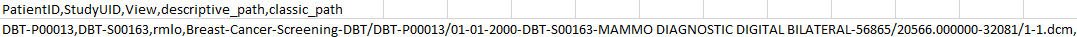

Vou precisar novamente renomear as paths do training set para que fiquem de acordo com a path no .csv (temos o "-NA-") na path do arquivo, que não existe no .csv).

In [2]:
#Código para renomear a path do training set
root_dir = r"E:\DukeDBT\TrainingDataset\manifest-1617905855234\Breast-Cancer-Screening-DBT"

#Acha o folder
for foldername, subfolders, filenames in os.walk(root_dir):
    for subfolder in subfolders:
        #Checa se tem o "-NA", que era o que tinha de diferente
        if '-NA' in subfolder:
            #Tira o "-NA" e deixa vazio colcando ''
            new_subfolder = subfolder.replace('-NA', '')
            old_path = os.path.join(foldername, subfolder)
            new_path = os.path.join(foldername, new_subfolder)
            #Faz o rename
            os.rename(old_path, new_path)

Depois de rodar o código, as paths estão corretas e é possível "andar" apropriadamente pelas paths dos arquivos.

E:\DukeDBT\TrainingDataset\manifest-1617905855234\Breast-Cancer-Screening-DBT\DBT-P00013\01-01-2000-DBT-S00163-MAMMO DIAGNOSTIC DIGITAL BILATERAL-56865\20566.000000-32081

In [3]:
#Ler os csvs das paths e da classificao de cada imagem
df_descriptive = pd.read_csv(r"E:\DukeDBT\TrainingDataset\BCS-DBT-file-paths-train-v2.csv")
df_classification = pd.read_csv(r"E:\DukeDBT\TrainingDataset\BCS-DBT-labels-train-v2.csv")

#Essa path é para adicionar antes da descriptive_path para ele achar as imagens no meu PC
additional_path = r"E:\DukeDBT\TrainingDataset\manifest-1617905855234" 

#Local que serão salvas as imagens do test set
data_folder = r"D:\Coisinhas\Coisas_UNB\TCC\dataset_png\train"
os.makedirs(data_folder, exist_ok=True)

#Folder das classes
class_folders = ['normal', 'actionable', 'benign', 'cancer']
for folder in class_folders:
    os.makedirs(os.path.join(data_folder, folder), exist_ok=True)

#Vai olhando os folders a partir da descriptive_path junto com a path do meu PC
for index, row in df_descriptive.iterrows():
    descriptive_path = os.path.join(additional_path, row['descriptive_path'])
    patient_id = row['PatientID']
    view = row['View']
    
    #Classificacao das imagens a partir das informacoes do .csv
    #Faz um "novo" dataset a partir das informacoes
    classification_row = df_classification[(df_classification['PatientID'] == patient_id) & (df_classification['StudyUID'] == row['StudyUID']) & (df_classification['View'] == view)]
    
    #Relaciona as informacoes do "novo" dataset com as infos do dataset de classificacoes para colocar na pasta certa
    classification = classification_row.iloc[0]['Normal'], classification_row.iloc[0]['Actionable'], classification_row.iloc[0]['Benign'], classification_row.iloc[0]['Cancer']
    
    #Vai orgranizar o folder da classe e do destino
    class_folder = class_folders[classification.index(1)]
    destination_folder = os.path.join(data_folder, class_folder)
    
    #Vai checar se a imagem já existe antes, fiz isso em caso de erro do código e se eu tiver que rodar denovo (o que vai acontecer)
    image_name = f"{patient_id}_{view}.png"
    destination_path = os.path.join(destination_folder, image_name)
    if not os.path.exists(destination_path):
        try:
            #Carrega DICOM
            ds = dicom.dcmread(descriptive_path)
            
            #Conversao para pixel array
            pixel_array = ds.pixel_array[0]
            
            #Normalização, se não os pixels ficam com valores muito altos
            pixel_array = pixel_array.astype(np.float32)
            pixel_array -= np.min(pixel_array)
            pixel_array /= np.max(pixel_array)
            pixel_array *= 255
            pixel_array = pixel_array.astype(np.uint8)
  
            #Conversão para imagem
            image = Image.fromarray(pixel_array)
            
            #Salvar para png
            image.save(destination_path)
        except Exception as e:
            print(f"Error occurred for image: {image_name}. Skipping...")
            continue

## 2 - Organização do validation set

Agora fazemos o mesmo para o validation set, começando pelo rename da path.



E:\DukeDBT\ValidationDataset\manifest-1617905855234\Breast-Cancer-Screening-DBT\DBT-P00002\01-01-2000-DBT-S03345-MAMMO diagnostic digital bilateral-69013\21098.000000-NA-91129

In [4]:
#Código para renomear a path do training set
root_dir = r"E:\DukeDBT\ValidationDataset\manifest-1617905855234\Breast-Cancer-Screening-DBT"

#Acha o folder
for foldername, subfolders, filenames in os.walk(root_dir):
    for subfolder in subfolders:
        #Checa se tem o "-NA", que era o que tinha de diferente
        if '-NA' in subfolder:
            #Tira o "-NA" e deixa vazio colcando ''
            new_subfolder = subfolder.replace('-NA', '')
            old_path = os.path.join(foldername, subfolder)
            new_path = os.path.join(foldername, new_subfolder)
            #Faz o rename
            os.rename(old_path, new_path)

In [5]:
#Ler os csvs das paths e da classificao de cada imagem
df_descriptive = pd.read_csv(r"E:\DukeDBT\ValidationDataset\BCS-DBT-file-paths-validation-v2.csv")
df_classification = pd.read_csv(r"E:\DukeDBT\ValidationDataset\BCS-DBT-labels-validation-PHASE-2-Jan-2024.csv")

#Essa path é para adicionar antes da descriptive_path para ele achar as imagens no meu PC
additional_path = r"E:\DukeDBT\ValidationDataset\manifest-1617905855234" 

#Local que serão salvas as imagens do test set
data_folder = r"D:\Coisinhas\Coisas_UNB\TCC\dataset_png\val"
os.makedirs(data_folder, exist_ok=True)

#Folder das classes
class_folders = ['normal', 'actionable', 'benign', 'cancer']
for folder in class_folders:
    os.makedirs(os.path.join(data_folder, folder), exist_ok=True)

#Vai olhando os folders a partir da descriptive_path junto com a path do meu PC
for index, row in df_descriptive.iterrows():
    descriptive_path = os.path.join(additional_path, row['descriptive_path'])
    patient_id = row['PatientID']
    view = row['View']
    
    #Classificacao das imagens a partir das informacoes do .csv
    #Faz um "novo" dataset a partir das informacoes
    classification_row = df_classification[(df_classification['PatientID'] == patient_id) & (df_classification['StudyUID'] == row['StudyUID']) & (df_classification['View'] == view)]
    
    #Relaciona as informacoes do "novo" dataset com as infos do dataset de classificacoes para colocar na pasta certa
    classification = classification_row.iloc[0]['Normal'], classification_row.iloc[0]['Actionable'], classification_row.iloc[0]['Benign'], classification_row.iloc[0]['Cancer']
    
    #Vai orgranizar o folder da classe e do destino
    class_folder = class_folders[classification.index(1)]
    destination_folder = os.path.join(data_folder, class_folder)
    
    #Vai checar se a imagem já existe antes, fiz isso em caso de erro do código e se eu tiver que rodar denovo (o que vai acontecer)
    image_name = f"{patient_id}_{view}.png"
    destination_path = os.path.join(destination_folder, image_name)
    if not os.path.exists(destination_path):
        try:
            #Carrega DICOM
            ds = dicom.dcmread(descriptive_path)
            
            #Conversao para pixel array
            pixel_array = ds.pixel_array[0]
            
            #Normalização, se não os pixels ficam com valores muito altos
            pixel_array = pixel_array.astype(np.float32)
            pixel_array -= np.min(pixel_array)
            pixel_array /= np.max(pixel_array)
            pixel_array *= 255
            pixel_array = pixel_array.astype(np.uint8)
  
            #Conversão para imagem
            image = Image.fromarray(pixel_array)
            
            #Salvar para png
            image.save(destination_path)
        except Exception as e:
            print(f"Error occurred for image: {image_name}. Skipping...")
            continue

In [43]:
def plot_image_counts(folder_path):
    #Contadores pra plotar
    counts = {'actionable': 0, 'benign': 0, 'cancer': 0, 'normal': 0}

    #Vai olhar os folders
    total_images = 0
    for class_name in counts.keys():
        class_path = os.path.join(folder_path, class_name)
        if os.path.exists(class_path):
            class_count = len(os.listdir(class_path))
            counts[class_name] = class_count
            total_images += class_count

    #Cálculo da porcentagem
    percentages = {class_name: count / total_images * 100 for class_name, count in counts.items()}

    #Plot dos gráficos
    plt.figure(figsize=(10, 6))
    plt.bar(percentages.keys(), percentages.values(), color=['blue', 'green', 'red', 'purple'])
    plt.xlabel('Classe')
    plt.ylabel('Porcentagem')
    plt.title('Porcentagem de imagens em cada classe')
    plt.show()

    #Tabelinha
    df = pd.DataFrame({'Quantidade': counts.values(), 'Porcentagem': percentages.values()}, index=counts.keys())
    print("Tabela quantidade-porcentagem:")
    print(df)

## 3 - Visualização da quantidade de imagens por classes 

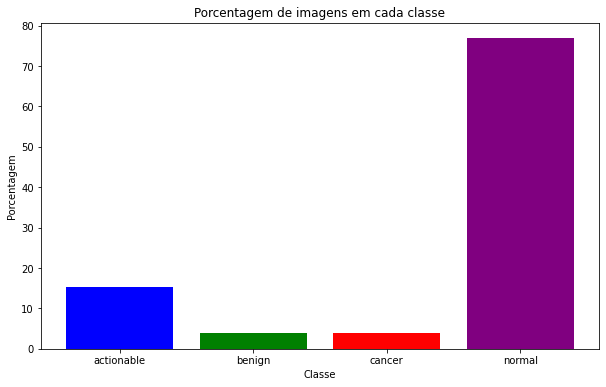

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         240    15.374760
benign              61     3.907751
cancer              60     3.843690
normal            1200    76.873799


In [44]:
#Test set
folder_path = r'D:/Coisinhas/Coisas_UNB/TCC/dataset_png/test'
plot_image_counts(folder_path)

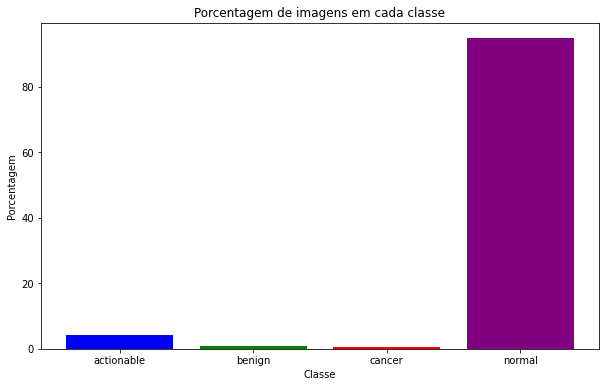

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         712     4.104220
benign             124     0.714780
cancer              76     0.438091
normal           16436    94.742910


In [45]:
#Training set
folder_path = r'D:/Coisinhas/Coisas_UNB/TCC/dataset_png/train'
plot_image_counts(folder_path)

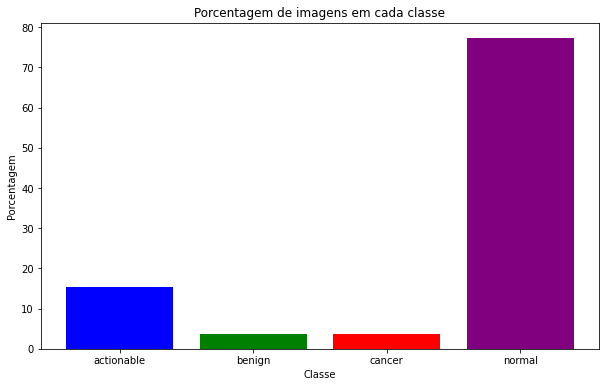

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         160    15.458937
benign              38     3.671498
cancer              37     3.574879
normal             800    77.294686


In [46]:
#Validation set
folder_path = r'D:/Coisinhas/Coisas_UNB/TCC/dataset_png/val'
plot_image_counts(folder_path)

Podemos ver que o dataset é extremamente desbalanceado. De acordo com o paper, tem-se que eles fizeram a seguinte divisão para o treinamento da rede:

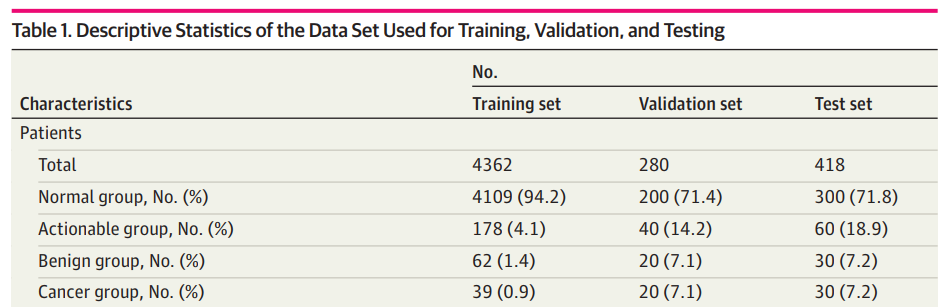

Convém testar essa divisão para o treinamento da rede.